In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


import tensorflow_addons as tfa

In [2]:
pose_sample_rpi_path = os.path.join(os.getcwd(), 'examples/lite/examples/pose_estimation/raspberry_pi')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
data_path = '/home/shellygoel2324/data_merged.csv'
#labels_path = '/home/shellygoel2324/processedLabels.csv'

In [4]:
def load_pose_landmarks(csv_path):
    """Loads a CSV created by MoveNetPreprocessor.
    Returns:
        X: Detected landmark coordinates and scores of shape (N, 17 * 3)
        y: Ground truth labels of shape (N, label_count)
        classes: The list of all class names found in the dataset
        dataframe: The CSV loaded as a Pandas dataframe features (X) and ground
        truth labels (y) to use later to train a pose classification model.
    """

    # Load the CSV file
    dataframe = pd.read_csv(csv_path)
    
    dataframe["label"] = dataframe["label"] - 1
  
    print(dataframe["label"].unique())
    
    
    curr_num = dataframe.loc[dataframe['label'] == 0]
    
    dataFinal = curr_num.sample(n=5000)
    #print(f"{i}:{curr_num_sub.shape}")
    #dataFinal.append(curr_num_sub)
    
    print(f"{0}:{dataFinal.shape}")
    
    '''
    0: 5000
    1:2500*2
        2: 1000*5
            3:250*20
                4: 250*20
                    5: 50*100
                
    '''
        
    for i in range(1, 6):
        
        curr_num = dataframe.loc[dataframe['label'] == i]
        
        '''
        num_s = 0
        if i == 1:
            num_s = 2
        if i == 2:
            num_s = 5
        if i == 3:
            num_s = 20
        if i == 4:
            num_s = 20     
        if i == 5:
            num_s = 100
            '''
        
        if i in [2,3,4]:
            sample_n = 7500
            
        elif i == 0:
            sample_n = 7000
        elif i == 1:
            sample_n = 8500
            
        else:
            sample_n = 5000
        
        curr_num_sub = curr_num.sample(n=sample_n, replace = True)
        print(f"{i}:{curr_num_sub.shape}")
        dataFinal = dataFinal.append(curr_num_sub, ignore_index=True)
        
    
    
    print(dataFinal.shape)
    
    dataframe = dataFinal
    labels = dataframe["label"]#pd.read_csv(labels_path, header=None)
    
    print(labels.unique())
    df_to_process = dataframe.copy()

    # Drop the file_name columns as you don't need it during training.
    df_to_process.drop(columns=['file_name'], inplace=True)

    # Extract the list of class names
    df_to_process.pop('class_name')
    df_to_process.pop('class_no')
    df_to_process.pop('label')

    # Extract the labels
    y = labels
    classes = range(6)

    # Convert the input features and labels into the correct format for training.
    X = df_to_process.astype('float64')
    y = keras.utils.to_categorical(y)

    return X, y, classes, dataframe

In [5]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(data_path)

print(X.shape, y.shape)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)

# 80/10/10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=1) # 0.25 x 0.8 = 0.2

#print(X_train.shape, X_val.shape, X_test.shape)

#60/20/20
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

[0. 3. 1. 2. 4. 5.]
0:(5000, 55)
1:(8500, 55)
2:(7500, 55)
3:(7500, 55)
4:(7500, 55)
5:(5000, 55)
(41000, 55)
[0. 1. 2. 3. 4. 5.]
(41000, 51) (41000, 6)


In [6]:
print("TRAIN DISTRIBUTION")

sample_dist = []
for i in range(0,6):
    
    num_i = 0
    for sample in y_train:
            if tf.argmax(sample) == i:
                num_i+=1
    dist = num_i/len(y_train)
    print(f"{i}: {dist}")
    print(f"{i}: {num_i}")
    sample_dist.append(dist)


print("\nTEST DISTRIBUTION")
for i in range(0,6):
    
    num_i = 0
    for sample in y_test:
            if tf.argmax(sample) == i:
                num_i+=1

    dist = num_i/len(y_test)
    print(f"{i}: {dist}")
    #sample_dist.append(dist)

TRAIN DISTRIBUTION


2022-05-31 05:33:46.156966: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-31 05:33:46.157029: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cs229-vm-vm): /proc/driver/nvidia/version does not exist
2022-05-31 05:33:46.158345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0: 0.12185975609756097
0: 3997
1: 0.20670731707317072
1: 6780
2: 0.1833231707317073
2: 6013
3: 0.18164634146341463
3: 5958
4: 0.1846951219512195
4: 6058
5: 0.12176829268292683
5: 3994

TEST DISTRIBUTION
0: 0.12341463414634146
1: 0.20634146341463414
2: 0.18560975609756097
3: 0.18682926829268293
4: 0.17634146341463414
5: 0.12146341463414634


In [7]:
sample_dist = sample_dist/np.linalg.norm(sample_dist)
weight_balanced= [1/s for s in sample_dist]

print(sample_dist)
print(weight_balanced)
#weight_balanced = weight_balanced/np.linalg.norm(weight_balanced)
#print(weight_balanced)
#print(np.sum(weight_balanced))

[0.2928777  0.49680031 0.44059885 0.43656876 0.4438962  0.29265788]
[3.414394448727612, 2.012881211145172, 2.269638219119286, 2.2905898978791988, 2.252778905837614, 3.416959091528359]


In [8]:
class_weights = {}
for i in range(6):
    class_weights[i] = weight_balanced[i]

In [9]:
def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size.

        It is the maximum of two values:
        * Torso size multiplied by `torso_size_multiplier`
        * Maximum distance from pose center to any pose landmark
    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)

    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

    return pose_size


def normalize_pose_landmarks(landmarks):
    """Normalizes the landmarks translation by moving the pose center to (0,0) and
        scaling it to a constant pose size.
    """
    # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size

    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)

    return embedding

def no_normalization(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    landmarks = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Flatten the landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks[:, :, :2])

    return embedding

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """Plots the confusion matrix."""
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Normalize everything

In [11]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

 )                                                                                                
                                                                                                  
 tf.broadcast_to_1 (TFOpLambda)  (None, 17, 2)       0           ['tf.expand_dims_1[0][0]',       
                                                                  'tf.compat.v1.floor_div_1[0][0]'
                                                                 ]                                
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 2)           0           ['tf.math.multiply_4[0][0]',     
 mbda)                                                            'tf.math.multiply_5[0][0]']     
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 2)           0           ['tf.math.multiply_2[0][0]',     
 mbda)    

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [13]:
model.compile(
    optimizer='adam',
    loss=tfa.losses.SigmoidFocalCrossEntropy(),#'categorical_crossentropy',
    metrics=METRICS
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
#checkpoint_path = "weights.best.hdf5"

checkpoint_path = "weights.best.onlyfocalloss"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
2036/2050 [============================>.] - ETA: 0s - loss: 0.1848 - tp: 6266.0000 - fp: 1059.0000 - tn: 161821.0000 - fn: 26310.0000 - accuracy: 0.8600 - precision: 0.8554 - recall: 0.1924 - auc: 0.8968 - prc: 0.6580
Epoch 1: val_loss improved from inf to 0.12074, saving model to weights.best.onlyfocalloss


2022-05-31 05:34:16.791276: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 11s 4ms/step - loss: 0.1847 - tp: 6335.0000 - fp: 1071.0000 - tn: 162929.0000 - fn: 26465.0000 - accuracy: 0.8601 - precision: 0.8554 - recall: 0.1931 - auc: 0.8970 - prc: 0.6584 - val_loss: 0.1207 - val_tp: 1681.0000 - val_fp: 144.0000 - val_tn: 20356.0000 - val_fn: 2419.0000 - val_accuracy: 0.8958 - val_precision: 0.9211 - val_recall: 0.4100 - val_auc: 0.9588 - val_prc: 0.8393
Epoch 2/200
2037/2050 [============================>.] - ETA: 0s - loss: 0.1341 - tp: 12687.0000 - fp: 1654.0000 - tn: 161306.0000 - fn: 19905.0000 - accuracy: 0.8898 - precision: 0.8847 - recall: 0.3893 - auc: 0.9477 - prc: 0.7974
Epoch 2: val_loss improved from 0.12074 to 0.10390, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.1341 - tp: 12775.0000 - fp: 1668.0000 - t

INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0995 - tp: 19687.0000 - fp: 1792.0000 - tn: 162208.0000 - fn: 13113.0000 - accuracy: 0.9243 - precision: 0.9166 - recall: 0.6002 - auc: 0.9724 - prc: 0.8888 - val_loss: 0.0793 - val_tp: 2809.0000 - val_fp: 179.0000 - val_tn: 20321.0000 - val_fn: 1291.0000 - val_accuracy: 0.9402 - val_precision: 0.9401 - val_recall: 0.6851 - val_auc: 0.9832 - val_prc: 0.9307
Epoch 12/200
2047/2050 [============================>.] - ETA: 0s - loss: 0.0978 - tp: 19923.0000 - fp: 1868.0000 - tn: 161892.0000 - fn: 12829.0000 - accuracy: 0.9252 - precision: 0.9143 - recall: 0.6083 - auc: 0.9735 - prc: 0.8925
Epoch 12: val_loss improved from 0.07932 to 0.07611, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0977 - tp: 19955.0000 - fp: 1868.0000 -

Epoch 22/200
2037/2050 [============================>.] - ETA: 0s - loss: 0.0895 - tp: 21070.0000 - fp: 1754.0000 - tn: 161206.0000 - fn: 11522.0000 - accuracy: 0.9321 - precision: 0.9232 - recall: 0.6465 - auc: 0.9779 - prc: 0.9099
Epoch 22: val_loss did not improve from 0.06845
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0895 - tp: 21211.0000 - fp: 1766.0000 - tn: 162234.0000 - fn: 11589.0000 - accuracy: 0.9321 - precision: 0.9231 - recall: 0.6467 - auc: 0.9779 - prc: 0.9100 - val_loss: 0.0685 - val_tp: 3030.0000 - val_fp: 189.0000 - val_tn: 20311.0000 - val_fn: 1070.0000 - val_accuracy: 0.9488 - val_precision: 0.9413 - val_recall: 0.7390 - val_auc: 0.9876 - val_prc: 0.9481
Epoch 23/200
2034/2050 [============================>.] - ETA: 0s - loss: 0.0903 - tp: 21045.0000 - fp: 1743.0000 - tn: 160977.0000 - fn: 11499.0000 - accuracy: 0.9322 - precision: 0.9235 - recall: 0.6467 - auc: 0.9775 - prc: 0.9087
Epoch 23: val_loss improved from 0.06845 to 0.06691, saving

Epoch 33/200
2041/2050 [============================>.] - ETA: 0s - loss: 0.0854 - tp: 21926.0000 - fp: 1713.0000 - tn: 161567.0000 - fn: 10730.0000 - accuracy: 0.9365 - precision: 0.9275 - recall: 0.6714 - auc: 0.9800 - prc: 0.9184
Epoch 33: val_loss did not improve from 0.06225
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0855 - tp: 22031.0000 - fp: 1723.0000 - tn: 162277.0000 - fn: 10769.0000 - accuracy: 0.9365 - precision: 0.9275 - recall: 0.6717 - auc: 0.9800 - prc: 0.9184 - val_loss: 0.0627 - val_tp: 3031.0000 - val_fp: 139.0000 - val_tn: 20361.0000 - val_fn: 1069.0000 - val_accuracy: 0.9509 - val_precision: 0.9562 - val_recall: 0.7393 - val_auc: 0.9897 - val_prc: 0.9564
Epoch 34/200
2047/2050 [============================>.] - ETA: 0s - loss: 0.0855 - tp: 21948.0000 - fp: 1671.0000 - tn: 162089.0000 - fn: 10804.0000 - accuracy: 0.9365 - precision: 0.9293 - recall: 0.6701 - auc: 0.9801 - prc: 0.9192
Epoch 34: val_loss did not improve from 0.06225
2050/2050 [

Epoch 44/200
2040/2050 [============================>.] - ETA: 0s - loss: 0.0832 - tp: 22346.0000 - fp: 1733.0000 - tn: 161467.0000 - fn: 10294.0000 - accuracy: 0.9386 - precision: 0.9280 - recall: 0.6846 - auc: 0.9812 - prc: 0.9229
Epoch 44: val_loss did not improve from 0.05933
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0831 - tp: 22452.0000 - fp: 1739.0000 - tn: 162261.0000 - fn: 10348.0000 - accuracy: 0.9386 - precision: 0.9281 - recall: 0.6845 - auc: 0.9812 - prc: 0.9229 - val_loss: 0.0613 - val_tp: 3038.0000 - val_fp: 115.0000 - val_tn: 20385.0000 - val_fn: 1062.0000 - val_accuracy: 0.9522 - val_precision: 0.9635 - val_recall: 0.7410 - val_auc: 0.9904 - val_prc: 0.9594
Epoch 45/200
2034/2050 [============================>.] - ETA: 0s - loss: 0.0836 - tp: 22303.0000 - fp: 1685.0000 - tn: 161035.0000 - fn: 10241.0000 - accuracy: 0.9389 - precision: 0.9298 - recall: 0.6853 - auc: 0.9811 - prc: 0.9230
Epoch 45: val_loss did not improve from 0.05933
2050/2050 [

2040/2050 [============================>.] - ETA: 0s - loss: 0.0819 - tp: 22437.0000 - fp: 1630.0000 - tn: 161570.0000 - fn: 10203.0000 - accuracy: 0.9396 - precision: 0.9323 - recall: 0.6874 - auc: 0.9820 - prc: 0.9260
Epoch 55: val_loss did not improve from 0.05701
2050/2050 [==============================] - 6s 3ms/step - loss: 0.0819 - tp: 22545.0000 - fp: 1637.0000 - tn: 162363.0000 - fn: 10255.0000 - accuracy: 0.9396 - precision: 0.9323 - recall: 0.6873 - auc: 0.9820 - prc: 0.9260 - val_loss: 0.0575 - val_tp: 3066.0000 - val_fp: 110.0000 - val_tn: 20390.0000 - val_fn: 1034.0000 - val_accuracy: 0.9535 - val_precision: 0.9654 - val_recall: 0.7478 - val_auc: 0.9917 - val_prc: 0.9645
Epoch 56/200
2049/2050 [============================>.] - ETA: 0s - loss: 0.0806 - tp: 22778.0000 - fp: 1637.0000 - tn: 162283.0000 - fn: 10006.0000 - accuracy: 0.9408 - precision: 0.9330 - recall: 0.6948 - auc: 0.9825 - prc: 0.9281
Epoch 56: val_loss did not improve from 0.05701
2050/2050 [=============

Epoch 67/200
2035/2050 [============================>.] - ETA: 0s - loss: 0.0791 - tp: 22842.0000 - fp: 1570.0000 - tn: 161230.0000 - fn: 9718.0000 - accuracy: 0.9422 - precision: 0.9357 - recall: 0.7015 - auc: 0.9831 - prc: 0.9312
Epoch 67: val_loss did not improve from 0.05478
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0790 - tp: 23014.0000 - fp: 1581.0000 - tn: 162419.0000 - fn: 9786.0000 - accuracy: 0.9422 - precision: 0.9357 - recall: 0.7016 - auc: 0.9832 - prc: 0.9313 - val_loss: 0.0561 - val_tp: 3200.0000 - val_fp: 132.0000 - val_tn: 20368.0000 - val_fn: 900.0000 - val_accuracy: 0.9580 - val_precision: 0.9604 - val_recall: 0.7805 - val_auc: 0.9918 - val_prc: 0.9654
Epoch 68/200
2046/2050 [============================>.] - ETA: 0s - loss: 0.0791 - tp: 23017.0000 - fp: 1592.0000 - tn: 162088.0000 - fn: 9719.0000 - accuracy: 0.9424 - precision: 0.9353 - recall: 0.7031 - auc: 0.9832 - prc: 0.9314
Epoch 68: val_loss did not improve from 0.05478
2050/2050 [====

2036/2050 [============================>.] - ETA: 0s - loss: 0.0776 - tp: 23192.0000 - fp: 1670.0000 - tn: 161210.0000 - fn: 9384.0000 - accuracy: 0.9434 - precision: 0.9328 - recall: 0.7119 - auc: 0.9839 - prc: 0.9339
Epoch 78: val_loss improved from 0.05373 to 0.05327, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0777 - tp: 23360.0000 - fp: 1683.0000 - tn: 162317.0000 - fn: 9440.0000 - accuracy: 0.9435 - precision: 0.9328 - recall: 0.7122 - auc: 0.9839 - prc: 0.9338 - val_loss: 0.0533 - val_tp: 3223.0000 - val_fp: 106.0000 - val_tn: 20394.0000 - val_fn: 877.0000 - val_accuracy: 0.9600 - val_precision: 0.9682 - val_recall: 0.7861 - val_auc: 0.9928 - val_prc: 0.9693
Epoch 79/200
2043/2050 [============================>.] - ETA: 0s - loss: 0.0778 - tp: 23036.0000 - fp: 1603.0000 - tn: 161837.0000 - fn: 9652.0000 - accuracy: 0.9426 - precision: 0.9349 - re

2030/2050 [============================>.] - ETA: 0s - loss: 0.0769 - tp: 23154.0000 - fp: 1552.0000 - tn: 160848.0000 - fn: 9326.0000 - accuracy: 0.9442 - precision: 0.9372 - recall: 0.7129 - auc: 0.9840 - prc: 0.9349
Epoch 89: val_loss improved from 0.05284 to 0.05120, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0770 - tp: 23382.0000 - fp: 1575.0000 - tn: 162425.0000 - fn: 9418.0000 - accuracy: 0.9441 - precision: 0.9369 - recall: 0.7129 - auc: 0.9840 - prc: 0.9349 - val_loss: 0.0512 - val_tp: 3328.0000 - val_fp: 135.0000 - val_tn: 20365.0000 - val_fn: 772.0000 - val_accuracy: 0.9631 - val_precision: 0.9610 - val_recall: 0.8117 - val_auc: 0.9932 - val_prc: 0.9712
Epoch 90/200
2049/2050 [============================>.] - ETA: 0s - loss: 0.0783 - tp: 23238.0000 - fp: 1618.0000 - tn: 162302.0000 - fn: 9546.0000 - accuracy: 0.9432 - precision: 0.9349 - re

Epoch 101/200
2034/2050 [============================>.] - ETA: 0s - loss: 0.0751 - tp: 23503.0000 - fp: 1561.0000 - tn: 161159.0000 - fn: 9041.0000 - accuracy: 0.9457 - precision: 0.9377 - recall: 0.7222 - auc: 0.9848 - prc: 0.9374
Epoch 101: val_loss improved from 0.05120 to 0.04988, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0751 - tp: 23686.0000 - fp: 1577.0000 - tn: 162423.0000 - fn: 9114.0000 - accuracy: 0.9457 - precision: 0.9376 - recall: 0.7221 - auc: 0.9848 - prc: 0.9374 - val_loss: 0.0499 - val_tp: 3308.0000 - val_fp: 119.0000 - val_tn: 20381.0000 - val_fn: 792.0000 - val_accuracy: 0.9630 - val_precision: 0.9653 - val_recall: 0.8068 - val_auc: 0.9936 - val_prc: 0.9729
Epoch 102/200
2046/2050 [============================>.] - ETA: 0s - loss: 0.0763 - tp: 23657.0000 - fp: 1595.0000 - tn: 162085.0000 - fn: 9079.0000 - accuracy: 0.9457 - precis

Epoch 113/200
2032/2050 [============================>.] - ETA: 0s - loss: 0.0771 - tp: 23365.0000 - fp: 1626.0000 - tn: 160934.0000 - fn: 9147.0000 - accuracy: 0.9448 - precision: 0.9349 - recall: 0.7187 - auc: 0.9842 - prc: 0.9353
Epoch 113: val_loss did not improve from 0.04988
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0771 - tp: 23576.0000 - fp: 1639.0000 - tn: 162361.0000 - fn: 9224.0000 - accuracy: 0.9448 - precision: 0.9350 - recall: 0.7188 - auc: 0.9842 - prc: 0.9354 - val_loss: 0.0513 - val_tp: 3217.0000 - val_fp: 104.0000 - val_tn: 20396.0000 - val_fn: 883.0000 - val_accuracy: 0.9599 - val_precision: 0.9687 - val_recall: 0.7846 - val_auc: 0.9933 - val_prc: 0.9713
Epoch 114/200
2047/2050 [============================>.] - ETA: 0s - loss: 0.0755 - tp: 23670.0000 - fp: 1608.0000 - tn: 162152.0000 - fn: 9082.0000 - accuracy: 0.9456 - precision: 0.9364 - recall: 0.7227 - auc: 0.9847 - prc: 0.9374
Epoch 114: val_loss did not improve from 0.04988
2050/2050 [

Epoch 125/200
2033/2050 [============================>.] - ETA: 0s - loss: 0.0745 - tp: 23569.0000 - fp: 1512.0000 - tn: 161128.0000 - fn: 8959.0000 - accuracy: 0.9463 - precision: 0.9397 - recall: 0.7246 - auc: 0.9851 - prc: 0.9390
Epoch 125: val_loss improved from 0.04984 to 0.04853, saving model to weights.best.onlyfocalloss
INFO:tensorflow:Assets written to: weights.best.onlyfocalloss/assets
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0746 - tp: 23769.0000 - fp: 1529.0000 - tn: 162471.0000 - fn: 9031.0000 - accuracy: 0.9463 - precision: 0.9396 - recall: 0.7247 - auc: 0.9851 - prc: 0.9389 - val_loss: 0.0485 - val_tp: 3259.0000 - val_fp: 92.0000 - val_tn: 20408.0000 - val_fn: 841.0000 - val_accuracy: 0.9621 - val_precision: 0.9725 - val_recall: 0.7949 - val_auc: 0.9941 - val_prc: 0.9749
Epoch 126/200
2042/2050 [============================>.] - ETA: 0s - loss: 0.0751 - tp: 23682.0000 - fp: 1542.0000 - tn: 161818.0000 - fn: 8990.0000 - accuracy: 0.9463 - precisi

2049/2050 [============================>.] - ETA: 0s - loss: 0.0737 - tp: 23954.0000 - fp: 1555.0000 - tn: 162365.0000 - fn: 8830.0000 - accuracy: 0.9472 - precision: 0.9390 - recall: 0.7307 - auc: 0.9856 - prc: 0.9409
Epoch 136: val_loss did not improve from 0.04767
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0736 - tp: 23967.0000 - fp: 1557.0000 - tn: 162443.0000 - fn: 8833.0000 - accuracy: 0.9472 - precision: 0.9390 - recall: 0.7307 - auc: 0.9856 - prc: 0.9409 - val_loss: 0.0513 - val_tp: 3213.0000 - val_fp: 104.0000 - val_tn: 20396.0000 - val_fn: 887.0000 - val_accuracy: 0.9597 - val_precision: 0.9686 - val_recall: 0.7837 - val_auc: 0.9934 - val_prc: 0.9716
Epoch 137/200
2031/2050 [============================>.] - ETA: 0s - loss: 0.0733 - tp: 23772.0000 - fp: 1547.0000 - tn: 160933.0000 - fn: 8724.0000 - accuracy: 0.9473 - precision: 0.9389 - recall: 0.7315 - auc: 0.9856 - prc: 0.9411
Epoch 137: val_loss did not improve from 0.04767
2050/2050 [==============

2044/2050 [============================>.] - ETA: 0s - loss: 0.0723 - tp: 24244.0000 - fp: 1545.0000 - tn: 161975.0000 - fn: 8460.0000 - accuracy: 0.9490 - precision: 0.9401 - recall: 0.7413 - auc: 0.9862 - prc: 0.9429
Epoch 147: val_loss did not improve from 0.04638
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0722 - tp: 24320.0000 - fp: 1548.0000 - tn: 162452.0000 - fn: 8480.0000 - accuracy: 0.9490 - precision: 0.9402 - recall: 0.7415 - auc: 0.9862 - prc: 0.9430 - val_loss: 0.0479 - val_tp: 3297.0000 - val_fp: 87.0000 - val_tn: 20413.0000 - val_fn: 803.0000 - val_accuracy: 0.9638 - val_precision: 0.9743 - val_recall: 0.8041 - val_auc: 0.9943 - val_prc: 0.9761
Epoch 148/200
2036/2050 [============================>.] - ETA: 0s - loss: 0.0728 - tp: 23995.0000 - fp: 1591.0000 - tn: 161289.0000 - fn: 8581.0000 - accuracy: 0.9480 - precision: 0.9378 - recall: 0.7366 - auc: 0.9859 - prc: 0.9418
Epoch 148: val_loss did not improve from 0.04638
2050/2050 [===============

Epoch 159/200
2042/2050 [============================>.] - ETA: 0s - loss: 0.0720 - tp: 24204.0000 - fp: 1520.0000 - tn: 161840.0000 - fn: 8468.0000 - accuracy: 0.9490 - precision: 0.9409 - recall: 0.7408 - auc: 0.9862 - prc: 0.9439
Epoch 159: val_loss did not improve from 0.04534
2050/2050 [==============================] - 5s 3ms/step - loss: 0.0720 - tp: 24305.0000 - fp: 1524.0000 - tn: 162476.0000 - fn: 8495.0000 - accuracy: 0.9491 - precision: 0.9410 - recall: 0.7410 - auc: 0.9862 - prc: 0.9439 - val_loss: 0.0471 - val_tp: 3298.0000 - val_fp: 90.0000 - val_tn: 20410.0000 - val_fn: 802.0000 - val_accuracy: 0.9637 - val_precision: 0.9734 - val_recall: 0.8044 - val_auc: 0.9944 - val_prc: 0.9761
Epoch 160/200
2038/2050 [============================>.] - ETA: 0s - loss: 0.0718 - tp: 24047.0000 - fp: 1550.0000 - tn: 161490.0000 - fn: 8561.0000 - accuracy: 0.9483 - precision: 0.9394 - recall: 0.7375 - auc: 0.9864 - prc: 0.9432
Epoch 160: val_loss did not improve from 0.04534
2050/2050 [=

Epoch 171/200
2044/2050 [============================>.] - ETA: 0s - loss: 0.0710 - tp: 24196.0000 - fp: 1527.0000 - tn: 161993.0000 - fn: 8508.0000 - accuracy: 0.9489 - precision: 0.9406 - recall: 0.7398 - auc: 0.9865 - prc: 0.9443
Epoch 171: val_loss did not improve from 0.04534
2050/2050 [==============================] - 7s 3ms/step - loss: 0.0709 - tp: 24273.0000 - fp: 1527.0000 - tn: 162473.0000 - fn: 8527.0000 - accuracy: 0.9489 - precision: 0.9408 - recall: 0.7400 - auc: 0.9865 - prc: 0.9444 - val_loss: 0.0464 - val_tp: 3329.0000 - val_fp: 92.0000 - val_tn: 20408.0000 - val_fn: 771.0000 - val_accuracy: 0.9649 - val_precision: 0.9731 - val_recall: 0.8120 - val_auc: 0.9944 - val_prc: 0.9766
Epoch 172/200
2034/2050 [============================>.] - ETA: 0s - loss: 0.0712 - tp: 24219.0000 - fp: 1549.0000 - tn: 161171.0000 - fn: 8325.0000 - accuracy: 0.9494 - precision: 0.9399 - recall: 0.7442 - auc: 0.9866 - prc: 0.9448
Epoch 172: val_loss did not improve from 0.04534
2050/2050 [=

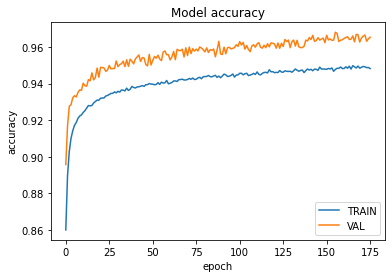

In [14]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

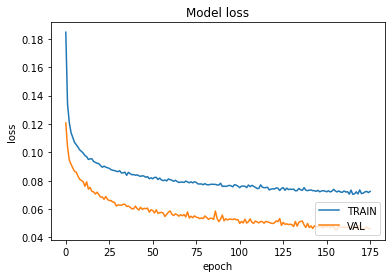

In [15]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [16]:
loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(X_test, y_test)

129/129 [==============================] - 0s 2ms/step - loss: 0.0785 - tp: 2739.0000 - fp: 116.0000 - tn: 20384.0000 - fn: 1361.0000 - accuracy: 0.9400 - precision: 0.9594 - recall: 0.6680 - auc: 0.9823 - prc: 0.9311


Normalized confusion matrix

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.68      0.80       506
           1       0.85      0.84      0.85       846
           2       0.82      0.88      0.85       761
           3       0.79      0.77      0.78       766
           4       0.81      0.92      0.86       723
           5       0.94      0.99      0.96       498

    accuracy                           0.85      4100
   macro avg       0.87      0.85      0.85      4100
weighted avg       0.85      0.85      0.85      4100



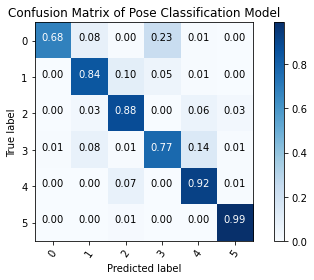

In [17]:
# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,normalize=True,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))

In [18]:
#Classes 3, 4 Need to be weighted

